# Phasor Plot Analysis for Lifetime Unmixing

In [1]:
import napari
import tifffile
import numpy as np
import pandas as pd
import dask.array as da
import pyclesperanto_prototype as cle
from pathlib import Path
from napari.utils import nbscreenshot
from skimage.measure import regionprops_table
from sklearn.cluster import KMeans

from napari_flim_phasor_plotter.filters import apply_binning
from napari_flim_phasor_plotter._reader import read_stack
from napari_flim_phasor_plotter._widget import make_flim_phasor_plot, split_n_largest_cluster_labels, smooth_cluster_mask

from utilities import format_metadata, set_plot_zoom_position
import warnings
warnings.filterwarnings("ignore")

%load_ext watermark

/home/pol_haase/mazo260d/miniforge3/envs/lifetime-env2/lib/python3.9/site-packages/pytools/persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


## Inputs
### Input data paths

Additional metadata in case xml file is missing

In [2]:
z_pixel_size = 0.5*1e-6 # in m
pixel_size_unit = 'm'
time_resolution_per_slice = 0.663 # in seconds
time_unit = 's'
channel_names = ['Gut Autofluorescence', 'Germline Cells']

Plotting related inputs

In [3]:
# Number of bins in 2D histogram
bins = 400

# Axis limits for 2D histogram
x_lim = (-0.05, 1.05)
y_lim = (0.0, 0.55)

timelapse_flag = False

Phasor generation related inputs

In [4]:
# Manual threshold value for phasor plot
threshold = 15

# Median filter iteration number
median_filter_iteration = 3

# Harmonic number
harmonic = 3

# Binning settings
binning = False
binning_kernel_size = 3
binning_3D = False

Post-processing related inputs

In [5]:
clustering_method = 'KMeans'
n_clusters = 2
n_iter = 300

# minimal area in pixels of holes to be filled
fill_area_px = 16
# radius for morphological closing and opening (objects smaller than this will be removed, gaps smaller than this will be connected)
smooth_radius = 1
# voronoi_otsu_spot+sigma
spot_sigma = 2
# voronoi_otsu_outline_sigma
outline_sigma = 1

Sample related inputs

In [6]:
folder_data_path = Path("/home/pol_haase/mazo260d/Data/I227_Lifetime_Unmixing_of_Dyes_with_Overlapping_Sprectra/worm_data/AZ212_sptw") # analyze channel 0

Create Output directories

In [7]:
sample_name = folder_data_path.stem
xml_path = None
# Create output folders
output_path = Path(folder_data_path) / 'Outputs'
output_path.mkdir(exist_ok=True)
segmentation_output_path = output_path / 'Segmentation'
segmentation_output_path.mkdir(exist_ok=True)
phasor_plots_output_path = output_path / 'Phasor Plots'
phasor_plots_output_path.mkdir(exist_ok=True)
screenshots_output_path = output_path / 'Screenshots'
screenshots_output_path.mkdir(exist_ok=True)
omero_output_path = output_path / 'OME-TIFFs'
omero_output_path.mkdir(exist_ok=True)


Get data and metadata paths

In [8]:
for file in folder_data_path.iterdir():
    # Read the zarr and a single xml file
    if file.suffix == '.zarr':
        zarr_data_path = file
    if file.suffix == '.xml':
        xml_path = file

Read data and metadata

In [9]:
# Read the zarr file
data, flim_metadata = read_stack(zarr_data_path)
summed_intensity_stack = da.sum(data, axis=1).astype(np.uint32)
print("Extracting metadata...")
if xml_path is None:
    print("No xml file found. Using additional metadata.")
else:
    if not xml_path.exists():
        print("The xml file does not exist. Using additional metadata.")
    else:
        print(f"Reading metadata from: {xml_path} and zarr file.")
# Extract metadata
metadata_timelapse, metadata_single_timepoint = format_metadata(
    flim_metadata,
    xml_path, 
    data.shape,
    z_pixel_size,
    pixel_size_unit,
    time_resolution_per_slice,
    time_unit,
    channel_names,
    'CTZYX',
    timelapse_flag)

laser_frequency = flim_metadata[0]['frequency']/1e6 # in MHz
print(f'Laser frequency: {laser_frequency} MHz')
# Split channels
image_raw_FLIM_channel_0 = data[0] # first channel
image_raw_FLIM_channel_1 = data[1] # second channel

stack = True 
data type:  .zarr 
data_shape =  (2, 268, 1, 78, 128, 512) 

Extracting metadata...
Reading metadata from: /home/pol_haase/mazo260d/Data/I227_Lifetime_Unmixing_of_Dyes_with_Overlapping_Sprectra/worm_data/AZ212_sptw/AZ212.xml and zarr file.
Laser frequency: 39.01 MHz


Write ome-tif file

In [10]:
output_file_name =  sample_name + f'.ome.tif'
with tifffile.TiffWriter(omero_output_path / output_file_name, ome=True) as tif:
    tif.write(data[:,:,0], metadata=metadata_single_timepoint, compression='zlib')

Get channel to phasor analyze

In [11]:
image_raw_FLIM_channel_0 = np.asarray(image_raw_FLIM_channel_0)

Optionally apply binning

In [12]:
# Apply binning (if True)
if binning:
    image_raw_FLIM_channel_0 = apply_binning(image_raw_FLIM_channel_0,
                                                    bin_size=binning_kernel_size,
                                                    binning_3D=binning_3D)

Generate intensity image from raw FLIM image

In [13]:
image_intensity_channel_0 = np.sum(image_raw_FLIM_channel_0, axis=0)
image_intensity_channel_1 = np.sum(image_raw_FLIM_channel_1, axis=0)

print(f"{sample_name} max intensity: {image_intensity_channel_0.max()}")
print(f"{sample_name} average intensity: {image_intensity_channel_0.mean()}")

AZ212_sptw max intensity: 505
AZ212_sptw average intensity: 1.5431448129507213


Save summed intensity image

In [14]:
output_file_name =  sample_name + f'_summed_intensity.ome.tif'
with tifffile.TiffWriter(omero_output_path / output_file_name, ome=True) as tif:
    tif.write(summed_intensity_stack, metadata=metadata_timelapse, compression='zlib')

## Workflow 1 - Segment Channel 0 Summed Intensity Directly
### Segment Image using Voronoi-Otsu-Labeling

In [15]:
labels_1 = np.asarray(cle.voronoi_otsu_labeling(np.squeeze(image_intensity_channel_0), spot_sigma=spot_sigma, outline_sigma=outline_sigma))

4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.


size: 78


4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.


In [16]:
print(f"Found {labels_1.max()} objects.")

Found 139 objects.


### Get objects features and save measurements

In [17]:
table = pd.DataFrame(regionprops_table(labels_1, properties=('label', 'area', 'centroid')))
table['sample'] = sample_name
table.to_csv(output_path / f'{sample_name}_segmentation_from_channel_0_measurements_table.csv', index=False)

### Write Results as ome-tif with segmentation as new channel

In [18]:
labels_1 = labels_1[np.newaxis, np.newaxis, :]
labels_1.shape

(1, 1, 78, 128, 512)

In [19]:
summed_intensity_stack_with_labels_1 = da.concatenate([summed_intensity_stack, labels_1], axis=0)
summed_intensity_stack_with_labels_1.shape

(3, 1, 78, 128, 512)

In [20]:
metadata_timelapse['Channel']['Name'].append('Segmentation from HyD X 4')
metadata_timelapse['Channel']['EmissionWavelength'].append(1)
metadata_timelapse['Channel']['EmissionWavelengthUnit'].append('nm')
metadata_timelapse['Channel']['ExcitationWavelength'].append(1)
metadata_timelapse['Channel']['ExcitationWavelengthUnit'].append('nm')
metadata_timelapse

{'axes': 'CTZYX',
 'PhysicalSizeX': 0.54,
 'PhysicalSizeXUnit': 'µm',
 'PhysicalSizeY': 0.54,
 'PhysicalSizeYUnit': 'µm',
 'PhysicalSizeZ': 0.5,
 'PhysicalSizeZUnit': 'µm',
 'AcquisitionDate': '23/02/22 12:49:27.658 PM',
 'Channel': {'Name': ['HyD X 2', 'HyD X 4', 'Segmentation from HyD X 4'],
  'EmissionWavelength': [530.0, 704.9999985, 1],
  'EmissionWavelengthUnit': ['nm', 'nm', 'nm'],
  'ExcitationWavelength': [480.0, 590.0, 1],
  'ExcitationWavelengthUnit': ['nm', 'nm', 'nm']}}

In [21]:
output_file_name =  sample_name + f'_summed_intensity_with_segmentation_from_channel_0.ome.tif'
with tifffile.TiffWriter(omero_output_path / output_file_name, ome=True) as tif:
    tif.write(summed_intensity_stack_with_labels_1, metadata=metadata_timelapse, compression='zlib')

## Workflow 2 - Split Channel 0 with Phasor Plot Clustering and Segment Pseudo-Channel

### Add images to viewer

In [22]:
# Add images to napari viewer
viewer = napari.Viewer()
viewer.add_image(image_raw_FLIM_channel_0, name=(sample_name + ' raw channel 0'), blending='additive', colormap='cyan')
viewer.add_image(image_intensity_channel_0, name=(sample_name + ' intensity channel 0'), colormap='cyan')
viewer.add_image(image_intensity_channel_1, name=(sample_name + ' intensity channel 1'), colormap='magenta', blending='additive')

# Adjust viewer visualization (3D display, first microtime)
viewer.dims.ndisplay = 3
viewer.dims.current_step = (0, 0, 10, 128, 128)

Assistant skips harvesting pyclesperanto as it's not installed.


### Generate phasor plot

In [23]:
plot_maker_widget = make_flim_phasor_plot()
# Generate phasor plot
phasor_plot_widget, labels_layer = plot_maker_widget(image_layer = viewer.layers[(sample_name + ' raw channel 0')],
                        laser_frequency = laser_frequency,
                        harmonic = harmonic,
                        threshold = threshold,
                        apply_median = True,
                        median_n = median_filter_iteration,
                        napari_viewer = viewer)

### Optimize phasor visualization and phasor plot position

In [24]:
phasor_plot_widget.bin_auto.setChecked(False)
phasor_plot_widget.bin_number_spinner.setValue(bins)
phasor_plot_widget.bin_number_set.clicked.emit(True)
set_plot_zoom_position(phasor_plot_widget, x_lim, y_lim)

### Save screenshots and phasor plot

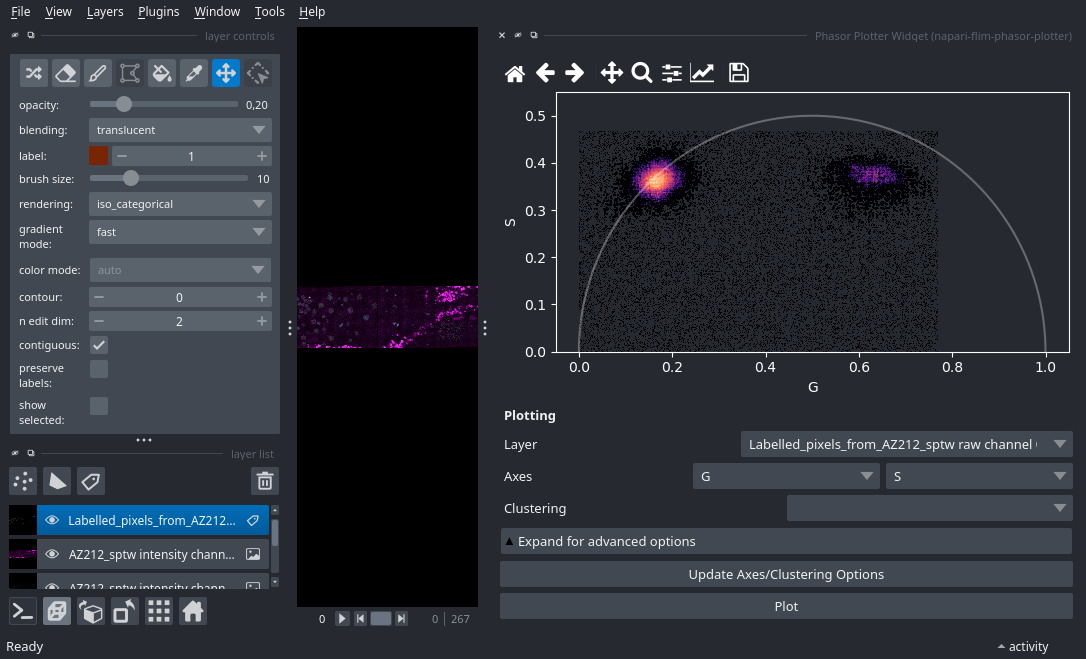

In [25]:
nbscreenshot(viewer)

In [26]:
# Save screenshot
screenshot = viewer.screenshot(canvas_only=False)
tifffile.imwrite(screenshots_output_path / f"{sample_name}_screenshot.png", screenshot)

# Save phasor plot before clustering
phasor_plot_widget.graphics_widget.axes.figure.savefig(phasor_plots_output_path / f'{sample_name}_phasor_plot.png', dpi=300)

### Make labels layer with labelled pixels (labels) the active layer

In [27]:
for choice in phasor_plot_widget.layer_select.choices:
    if choice.name.startswith('Labelled_pixels_from_'):
        viewer.layers.selection.active = choice
        break

### Get features table with phasor and pixel coordinates

In [28]:
features_table = labels_layer.features
features_table

,label,G,S,pixel_x_coordinates,pixel_y_coordinates,pixel_z_coordinates,frame
0,1,0.208694,0.290248,208,62,0,0
1,2,0.181337,0.421088,210,67,0,0
2,3,0.184836,0.414989,34,72,0,0
3,4,0.154356,0.369748,32,73,0,0
4,5,0.184836,0.394560,34,73,0,0
...,...,...,...,...,...,...,...
36507,36508,0.507885,0.358409,492,62,76,0
36508,36509,0.507874,0.378868,493,62,76,0
36509,36510,0.503075,0.347453,492,60,77,0
36510,36511,0.411078,0.388141,494,60,77,0


### Cluster with KMeans

In [29]:
clustering_kmeans = KMeans(n_clusters=n_clusters, max_iter=n_iter)
kmeans_predictions = clustering_kmeans.fit_predict(features_table[['G', 'S']])
clustering_id = "KMEANS_CLUSTER_ID"

In [30]:
features_table[clustering_id] = kmeans_predictions
features_table

,label,G,S,pixel_x_coordinates,pixel_y_coordinates,pixel_z_coordinates,frame,KMEANS_CLUSTER_ID
0,1,0.208694,0.290248,208,62,0,0,0
1,2,0.181337,0.421088,210,67,0,0,0
2,3,0.184836,0.414989,34,72,0,0,0
3,4,0.154356,0.369748,32,73,0,0,0
4,5,0.184836,0.394560,34,73,0,0,0
...,...,...,...,...,...,...,...,...
36507,36508,0.507885,0.358409,492,62,76,0,1
36508,36509,0.507874,0.378868,493,62,76,0,1
36509,36510,0.503075,0.347453,492,60,77,0,1
36510,36511,0.411078,0.388141,494,60,77,0,1


### Update features table in layer

In [31]:
labels_layer.features = features_table
phasor_plot_widget.update_axes_and_clustering_id_lists()
phasor_plot_widget.plot_cluster_id.setCurrentText(clustering_id)

### Display KMeans predictions

In [32]:
phasor_plot_widget.run(
    labels_layer.features,
    phasor_plot_widget.plot_x_axis.currentText(),
    phasor_plot_widget.plot_y_axis.currentText(),
    phasor_plot_widget.plot_cluster_id.currentText(),
)
set_plot_zoom_position(phasor_plot_widget, x_lim, y_lim)

In [33]:
clusters_labels_layer = phasor_plot_widget.visualized_layer

### Save phasor plot after cluster selection

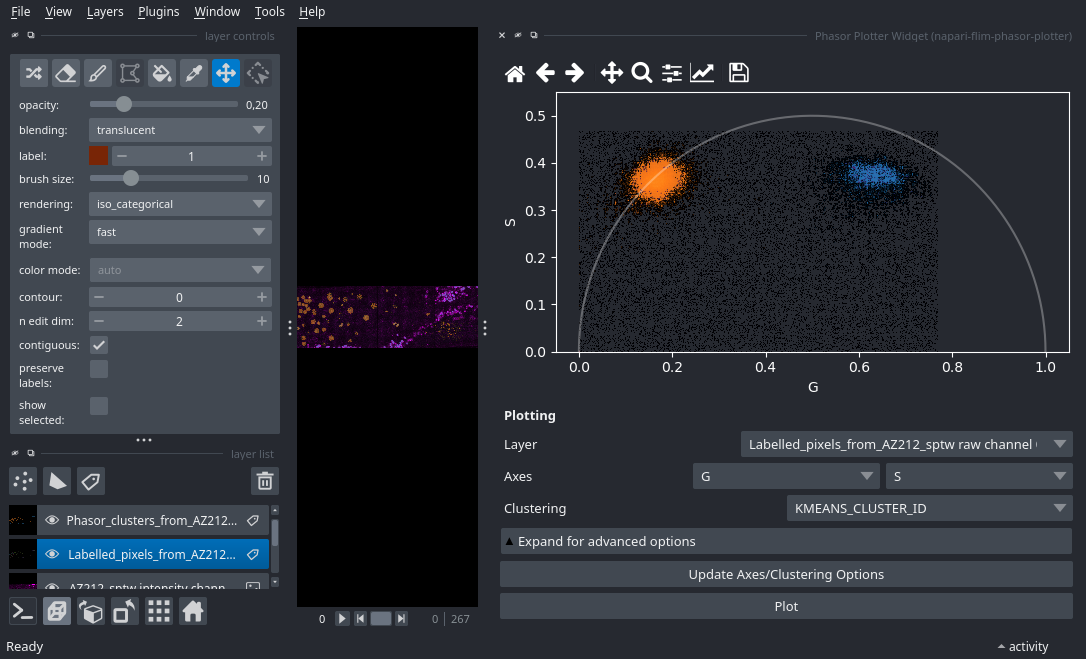

In [34]:
nbscreenshot(viewer)

In [35]:
phasor_plot_widget.graphics_widget.axes.figure.savefig(phasor_plots_output_path / f'{sample_name}_phasor_plot_after_cluster_selection.png', dpi=300)

### Save clusters masks

In [36]:
clusters_masks = clusters_labels_layer.data.astype(np.uint8)

# save segmentation results with tifffile
tifffile.imsave(segmentation_output_path / f'{sample_name}_cluster_masks.tiff', 
                clusters_masks, imagej=True)

### Split masks

In [37]:
list_of_labels_layers = split_n_largest_cluster_labels(
    labels_layer=labels_layer,
    clusters_labels_layer=clusters_labels_layer,
    clustering_id=clustering_id,
    n=n_clusters,
)

cluster_mask_image_0 = list_of_labels_layers[0].data
cluster_mask_image_1 = list_of_labels_layers[1].data

### Smooth Channel 0 Cluster 1 Mask

In [38]:
cluster_mask_layer_smoothed = smooth_cluster_mask(
                cluster_mask_layer = list_of_labels_layers[0],
                fill_area_px = fill_area_px,
                smooth_radius = smooth_radius)

### Segment Mask with Voronoi-Otsu-Labeling

In [39]:
labels_2 = np.asarray(cle.voronoi_otsu_labeling(np.squeeze(cluster_mask_layer_smoothed.data), spot_sigma=spot_sigma, outline_sigma=outline_sigma))
print(f"Found {labels_2.max()} objects.")

size: 78
Found 91 objects.


### Get objects features and save measurements

In [40]:
table = pd.DataFrame(regionprops_table(labels_2, properties=('label', 'area', 'centroid')))
table['sample'] = sample_name
table.to_csv(output_path / f'{sample_name}_segmentation_from_pseudo_channel_cluster_0_measurements_table.csv', index=False)

### Write Results as ome-tif with segmentation as new channel

In [41]:
labels_2 = labels_2[np.newaxis, np.newaxis, :]
labels_2.shape

(1, 1, 78, 128, 512)

In [42]:
summed_intensity_stack_with_labels_2 = da.concatenate([summed_intensity_stack, labels_2], axis=0)
summed_intensity_stack_with_labels_2.shape

(3, 1, 78, 128, 512)

In [43]:
metadata_timelapse['Channel']['Name'][-1] = 'Segmentation from HyD X 2 - Cluster 0'
metadata_timelapse

{'axes': 'CTZYX',
 'PhysicalSizeX': 0.54,
 'PhysicalSizeXUnit': 'µm',
 'PhysicalSizeY': 0.54,
 'PhysicalSizeYUnit': 'µm',
 'PhysicalSizeZ': 0.5,
 'PhysicalSizeZUnit': 'µm',
 'AcquisitionDate': '23/02/22 12:49:27.658 PM',
 'Channel': {'Name': ['HyD X 2',
   'HyD X 4',
   'Segmentation from HyD X 2 - Cluster 0'],
  'EmissionWavelength': [530.0, 704.9999985, 1],
  'EmissionWavelengthUnit': ['nm', 'nm', 'nm'],
  'ExcitationWavelength': [480.0, 590.0, 1],
  'ExcitationWavelengthUnit': ['nm', 'nm', 'nm']}}

In [44]:
output_file_name =  sample_name + f'_summed_intensity_with_segmentation_from_pseudo_channel_cluster_0.ome.tif'
with tifffile.TiffWriter(omero_output_path / output_file_name, ome=True) as tif:
    tif.write(summed_intensity_stack_with_labels_2, metadata=metadata_timelapse, compression='zlib')

### Extra: Save Image with Pseudo-Channels

Mask summed intensity

In [45]:
image_intensity_channel_0 = np.squeeze(image_intensity_channel_0)

In [46]:
image_intensity_channel_0_masked_0 = np.zeros_like(image_intensity_channel_0)
image_intensity_channel_0_masked_0[cluster_mask_image_0 > 0] = image_intensity_channel_0[cluster_mask_image_0 > 0]

image_intensity_channel_0_masked_1 = np.zeros_like(image_intensity_channel_0)
image_intensity_channel_0_masked_1[cluster_mask_image_1 > 0] = image_intensity_channel_0[cluster_mask_image_1 > 0]


Build stack with pseudo-channels

In [47]:
data_channel_split = np.stack([image_intensity_channel_0_masked_0, image_intensity_channel_0_masked_1, np.squeeze(image_intensity_channel_1)])
data_channel_split = data_channel_split[:, None]
data_channel_split.shape

(3, 1, 78, 128, 512)

Format metadata for pseudo-channels

In [48]:
metadata_timelapse['Channel']['Name'] = ['HyD X 2 - Cluster 0', 'HyD X 2 - Cluster 1', 'HyD X 4']
metadata_timelapse['Channel']['EmissionWavelength'].pop()
metadata_timelapse['Channel']['EmissionWavelength'].insert(0, metadata_timelapse['Channel']['EmissionWavelength'][0])
metadata_timelapse['Channel']['EmissionWavelengthUnit'].pop()
metadata_timelapse['Channel']['EmissionWavelengthUnit'].insert(0, metadata_timelapse['Channel']['EmissionWavelengthUnit'][0])
metadata_timelapse['Channel']['ExcitationWavelength'].pop()
metadata_timelapse['Channel']['ExcitationWavelength'].insert(0, metadata_timelapse['Channel']['ExcitationWavelength'][0])
metadata_timelapse['Channel']['ExcitationWavelengthUnit'].pop()
metadata_timelapse['Channel']['ExcitationWavelengthUnit'].insert(0, metadata_timelapse['Channel']['ExcitationWavelengthUnit'][0])
metadata_timelapse

{'axes': 'CTZYX',
 'PhysicalSizeX': 0.54,
 'PhysicalSizeXUnit': 'µm',
 'PhysicalSizeY': 0.54,
 'PhysicalSizeYUnit': 'µm',
 'PhysicalSizeZ': 0.5,
 'PhysicalSizeZUnit': 'µm',
 'AcquisitionDate': '23/02/22 12:49:27.658 PM',
 'Channel': {'Name': ['HyD X 2 - Cluster 0', 'HyD X 2 - Cluster 1', 'HyD X 4'],
  'EmissionWavelength': [530.0, 530.0, 704.9999985],
  'EmissionWavelengthUnit': ['nm', 'nm', 'nm'],
  'ExcitationWavelength': [480.0, 480.0, 590.0],
  'ExcitationWavelengthUnit': ['nm', 'nm', 'nm']}}

Save stack with pseudo-channels (channel 0 split)

In [49]:
output_file_name =  sample_name + f'_summed_intensity_channel_split.ome.tif'
with tifffile.TiffWriter(omero_output_path / output_file_name, ome=True) as tif:
    tif.write(data_channel_split.astype(np.uint32), metadata=metadata_timelapse, compression='zlib')

### Save table of phasors

In [50]:
features_table.to_csv(phasor_plots_output_path / f'{sample_name}_phasors_table.csv', index=False)

### Save config file

In [51]:
file_path = output_path / f'{sample_name}_config.txt'

# Writing to the file
with open(file_path, 'w') as file:
    file.write(f"sample_name = {sample_name}\n")
    file.write(f"clustering_method = {clustering_method}\n")
    file.write(f"number of clusters = {n_clusters}\n")
    file.write(f"number of iterations of clustering method = {n_iter}\n")
    file.write(f"bins = {bins}\n")
    file.write(f"x_lim = {x_lim}\n")
    file.write(f"y_lim = {y_lim}\n")
    file.write(f"threshold = {threshold}\n")
    file.write(f"median_filter_iteration = {median_filter_iteration}\n")
    file.write(f"harmonic = {harmonic}\n")
    file.write(f"binning = {binning}\n")
    file.write(f"binning_kernel_size = {binning_kernel_size}\n")
    file.write(f"binning_3D = {binning_3D}\n")
    file.write(f"fill_area_px = {fill_area_px}\n")
    file.write(f"smooth_radius = {smooth_radius}\n")
    file.write(f"spot_sigma = {spot_sigma}\n")
    file.write(f"outline_sigma = {outline_sigma}\n")

## Packages Versions and Machine Info

In [52]:
%watermark -v -m --gpu -p napari,numpy,napari_flim_phasor_plotter,pyclesperanto_prototype,tifffile,pandas,skimage,sklearn,dask

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.18.1

napari                    : 0.5.5
numpy                     : 1.23.5
napari_flim_phasor_plotter: 0.1.2
pyclesperanto_prototype   : 0.24.5
tifffile                  : 2022.8.12
pandas                    : 2.2.3
skimage                   : 0.24.0
sklearn                   : 1.6.0
dask                      : 2024.8.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 5.15.0-25-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 48
Architecture: 64bit

GPU Info: 
  GPU 0: NVIDIA RTX 6000 Ada Generation
  GPU 1: NVIDIA RTX 6000 Ada Generation

